In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# hyper params initalization
_batch_size = 128
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_lr_rate = 0.01
_momentum = 0.9
_epoch = 10

In [2]:
# load MNIST data set into data loader
mnist_train = datasets.MNIST("./data", train=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False,  transform=transforms.ToTensor())

idx_3, idx_7 = mnist_train.targets == 3, mnist_train.targets == 7
idx_train = idx_3 | idx_7

idx_3, idx_7 = mnist_test.targets == 3, mnist_test.targets == 7
idx_test = idx_3 | idx_7

mnist_train.targets = mnist_train.targets[idx_train]
mnist_train.data = mnist_train.data[idx_train]
mnist_test.targets = mnist_test.targets[idx_test]
mnist_test.data = mnist_test.data[idx_test]

# label 0: 3, label 1: 7 
mnist_train.targets = ((mnist_train.targets - 3)/4).float()
mnist_test.targets = ((mnist_test.targets - 3)/4).float()

train_loader = DataLoader(mnist_train, batch_size = _batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = _batch_size, shuffle=True)

In [3]:
avoid_zero_div = 1e-12

class pgd_rand(object):
    """ PGD attacks, with random initialization within the specified lp ball """
    def __init__(self, **kwargs):
        # define default attack parameters here:
        self.param = {'ord': np.inf,
                      'epsilon': 0.3,
                      'alpha': 0.01,
                      'num_iter': 40,
                      'restarts': 1,
                      'loss_fn': nn.BCEWithLogitsLoss()}
        # parse thru the dictionary and modify user-specific params
        self.parse_param(**kwargs) 
        
    def generate(self, model, x, y):
        epsilon = self.param['epsilon']
        alpha = self.param['alpha']
        num_iter = self.param['num_iter']
        restarts = self.param['restarts']
        loss_fn = self.param['loss_fn']
        p_norm = self.param['ord'] 
        
        # implementation begins:
        max_loss = torch.zeros(y.shape[0]).to(y.device)
        max_delta = torch.zeros_like(x)
        _dim = x.shape[1] * x.shape[2] * x.shape[3]
        
        for i in range(restarts):
            if p_norm == np.inf:
                delta = torch.rand_like(x, requires_grad=True)
                delta.data = delta.data * 2. * epsilon - epsilon
                delta.data = (x.data + delta.data).clamp(min = 0, max = 1.0) - x.data
                for t in range(num_iter):
                    model.zero_grad()
                    loss = loss_fn(model(x + delta), y)
                    loss.backward()
                    # first we need to make sure delta is within the specified lp ball
                    delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(min = -epsilon, max = epsilon)
                    # then we need to make sure x+delta in the next iteration is within the [0,1] range
                    delta.data = (x.data + delta.data).clamp(min = 0, max = 1.) - x.data
                    delta.grad.zero_()
            
            # added the if condition to cut 1 additional unnecessary foward pass
            if restarts > 1:
                all_loss = nn.CrossEntropyLoss(reduction='none')(model(x+delta),y)
                max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
                max_loss = torch.max(max_loss, all_loss)
            else:
                max_delta = delta.detach()
        return max_delta

    def parse_param(self, **kwargs):
        for key,value in kwargs.items():
            if key in self.param:
                self.param[key] = value


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 28, 1, bias = False)
        torch.nn.init.xavier_uniform(self.conv1.weight)

    def forward(self, x):
        output = self.conv1(x).view(-1,1)
        # print(output.shape)
        return output

In [5]:
def one_epoch(model, device, loader, opt, train = True, adv = False):
    total_correct = 0
    if train:
        model.train()
    else:
        model.eval()

    with trange(len(loader)) as t:
        for X, y in loader:
            X, y = X.to(device), y.to(device).float().view(-1,1)

            opt.zero_grad()

            if adv:
                delta = pgd_rand().generate(model,X,y)
                yp = model(X+delta)
                loss = nn.BCEWithLogitsLoss()(yp, y)

            else:
                yp = model(X)
                loss = nn.BCEWithLogitsLoss()(yp, y)

            # ipdb.set_trace()

            if train:
                loss.backward()
                opt.step()

            # ipdb.set_trace()
            batch_correct = ((yp>0) == y).sum().item()
            total_correct += batch_correct
            batch_acc = batch_correct / X.shape[0]
            # total_loss_adv += loss_adv.item() * X.shape[0]

            t.set_postfix(loss = loss.item(), 
                        batch_acc = '{0:.2f}%'.format(batch_acc*100), 
                        total_acc = '{0:.2f}%'.format(total_correct/loader.dataset.data.shape[0]*100))
            t.update()

In [9]:
model = Net().to(_device)
# mask_weight(model, 13, device)
# init_weight = list(model.parameters())[0].data.view(28,28).detach().cpu().numpy()


opt = optim.SGD(model.parameters(), lr=_lr_rate)

for epoch in range(1, _epoch + 1):
    one_epoch(model, _device, train_loader, opt, train = True, adv = False)

/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
100%|██████████| 97/97 [00:01<00:00, 77.33it/s, batch_acc=97.22%, loss=0.116, total_acc=97.73%]  


In [26]:
train_loader = DataLoader(mnist_train, batch_size = 1, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 1, shuffle=True)


total_3_fft = np.zeros((28,28), dtype = np.complex128)
num_3 = 0
total_7_fft = np.zeros((28,28), dtype = np.complex128)
num_7 = 0

with trange(len(train_loader)) as t:
    for X,y in train_loader:
        X, y = X.to(_device), y.to(_device).float().view(-1,1)
        if y.item() == 0:
            delta = pgd_rand().generate(model,X,y)
            a = np.fft.fftshift(np.fft.fft2(delta.squeeze().detach().cpu().numpy()))
            
            total_3_fft += a
            num_3 += 1
        elif y.item() == 1:
            delta = pgd_rand().generate(model,X,y)
            a = np.fft.fftshift(np.fft.fft2(delta.squeeze().detach().cpu().numpy()))
            total_7_fft += a
            num_7 += 1
        t.update()

mean_3_fft = total_3_fft/num_3
mean_7_fft = total_7_fft/num_7

100%|██████████| 12396/12396 [06:24<00:00, 32.92it/s]


/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/h/ama/.conda/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import k

Text(0.5, 1.0, "Log Mean Fourier Spectrum of 3's")

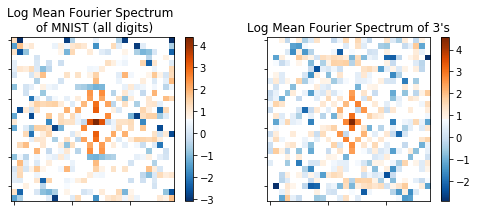

In [32]:
# blue: positive, red: negative
top = plt.cm.get_cmap('Blues', 128)
bottom = plt.cm.get_cmap('Oranges_r', 128)

newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(1, 0, 128))))
newcmp = colors.ListedColormap(newcolors, name='OrangeBlue')


fig_test = plt.figure(figsize = [13,3])
gs = fig_test.add_gridspec(1,3)
p1 = fig_test.add_subplot(gs[0,0]).imshow(np.log(np.real(mean_3_fft)), cmap = newcmp)
fig_test.colorbar(p1)
fig_test.add_subplot(gs[0,0]).set_yticklabels([])
fig_test.add_subplot(gs[0,0]).set_xticklabels([])
# fig_test.add_subplot(gs[0,0]).set_title('Log Mean Fourier Spectrum \n of MNIST:' + r'Log $\frac{1}{n}$ \Sigma F{x_{i}')
fig_test.add_subplot(gs[0,0]).set_title('Log Mean Fourier Spectrum \n of MNIST (all digits)')


p2 = fig_test.add_subplot(gs[0,1]).imshow(np.log(np.real(mean_7_fft)), cmap = newcmp)
fig_test.colorbar(p2)
fig_test.add_subplot(gs[0,1]).set_yticklabels([])
fig_test.add_subplot(gs[0,1]).set_xticklabels([])
fig_test.add_subplot(gs[0,1]).set_title('Log Mean Fourier Spectrum of 3\'s')

